# Pulsebuilding for QCoDeS part I

This set of tutorials covers the offline construction of pulse sequences from idea to numpy array to awg file. No instrument is required. In part one, we deal with individual pulse sequence elements. Part two covers sequences and awg files. 

## Lingo

Let's settle on a vocabulary. At the highest level, we construct **elements**. These elements will eventually become sequence elements of the AWG 5014 sequencer and can thus consist of different **subelements** corresponding to different channels of the AWG (or several AWGs). Each subelement consists of some number of **segments** (e.g. a ramp, a sine of a certain frequence, a pi-pulse, etc).

There is no reason to maintain a very clear distinction between subelements and elements, since a subelement becomes an element in the case of a single-channel element, and all subelements are in any case independent. For the remainder of this tutorial, we only refer to elements.

## Code abstractions

The pulse building module uses the concept of a **blueprint** which is eventually **forged** into an element. The blueprint is basically a list of segments; this is where the user specifies that "first comes a ramp, then a sine, then another ramp, ...". The forging into an element happens when the user provides the **durations** of the segments. 

## Code implementation

Each segment is either **special** or normal. 

### Normal segments

A normal segment consists of a _unique_ name, a function object, a tuple of arguments to the function, and an optional number of **timesteps**. 

 * The name: can be provided by the user or omitted. If omitted, the segment will get the name of its function. Since all names must be unique, the blueprint _appends numbers_ to names if they occur more than once. The numbers are appended chronologically throughout the blueprint. See example below.
 
 * The function: must be a python function taking at least one argument; the segment duration. If the function takes other arguments (such as ramp slope, frequency, etc.) the duration argument must be the last positional argument. Keyword arguments are currently not allowed.
 
 * The arguments: are in a tuple of $n-1$ arguments for a function taking $n$ arguments, i.e. specifying everything but the duration.
 
 * The number of timesteps: can be 1 (default) or more. This is needed if a segment on one channel is to last while several different segments are run through on another channel of the same element. See example below.


### Special segments

A special segment has a (protected) name and a number of arguments. So far, two special segments are implemented.
 
 * `waituntil`, args [time (int)]:  When put in a blueprint, this function ensures that the _next_ segment starts at the absolute time `time` after the start of the element. It does so by filling any excess time with zeros. It fails if the previous segment will finish after time `time`.
 
 * `makemeanfit`. Not implemented yet.

Let's go!

In [1]:
%matplotlib nbagg
import qcodes.instrument_drivers.tektronix.pulsebuilding as pb
import numpy as np

## Basic blueprinting

In [2]:
# The pulsebuilding module comes with a (small) collection of functions appropriate for being segments.
ramp = pb.PulseAtoms.ramp  # args: slope, offset
sine = pb.PulseAtoms.sine  # args: freq, ampl, off

# make a blueprint

# The blueprint takes three (the fourth optional) lists as input
bp1 = pb.BluePrint([ramp, sine, ramp],  # functions
                   [(-1, 0), (5, 1, 1), (2, 0)],  # arguments
                   ['', 'wiggle', ''],  # names
                   [1, 2, 1])  # (optional) timesteps

# The blueprint can be inspected
bp1.showPrint()

Segment 1: ramp, <function PulseAtoms.ramp at 0x1072c1488>, (-1, 0), 1
Segment 2: wiggle, <function PulseAtoms.sine at 0x109291510>, (5, 1, 1), 2
Segment 3: ramp2, <function PulseAtoms.ramp at 0x1072c1488>, (2, 0), 1


In [3]:
# Alternatively, one construct a blueprint by adding segments one-by-one
bp2 = pb.BluePrint([], [], [])
bp2.insertSegment(-1, ramp, (-1, 0))
bp2.insertSegment(-1, sine, (5, 1, 1), 'wiggle', 2)
bp2.insertSegment(-1, ramp, (2, 0))

# This achieves the same as the code above, as we may conclude by inspection...
bp2.showPrint()
# ... or by direct comparison
print('---')
print(bp1==bp2)

Segment 1: ramp, <function PulseAtoms.ramp at 0x1072c1488>, (-1, 0), 1
Segment 2: wiggle, <function PulseAtoms.sine at 0x109291510>, (5, 1, 1), 2
Segment 3: ramp2, <function PulseAtoms.ramp at 0x1072c1488>, (2, 0), 1
---
True


In [4]:
print(bp1.marker1)
print(bp2.marker1)

[]
[]


In [5]:
# It is also possible to copy blueprints
bp3 = bp1.copy()
print('Are bp1 and bp3 identical?', bp3==bp1)

# Let's say we now want to modify bp3 to have no sine function but only ramps
bp3.removeSegment('wiggle')  # remove the offending segment
bp3.insertSegment(1, ramp, (1, 0))  # insert a ramp before element 1 (the second element)
bp3.insertSegment(2, ramp, (0, 0))  # insert a ramp

# And let's say that we want to change the frequency of the sine of bp2
# we can adress the argument by its position...
bp2.changeArg('wiggle', 0, 2.5)
# ...or by its name (even though it's NOT a keyword argument)
bp2.changeArg('wiggle', 'freq', 2.5)

# Of course, the blueprints differ now
print('Are bp2 and bp3 still identical?', bp3==bp1)

Are bp1 and bp3 identical? True
Are bp2 and bp3 still identical? False


In [6]:
# It can be useful to add two blueprints together
bp4 = pb.BluePrint([ramp], [(1, 0)], [''])
bp5 = bp4.copy()
for ii in range(3):
    bp4.showPrint()
    print('--')
    bp4 += bp5

Segment 1: ramp, <function PulseAtoms.ramp at 0x1072c1488>, (1, 0), 1
--
Segment 1: ramp, <function PulseAtoms.ramp at 0x1072c1488>, (1, 0), 1
Segment 2: ramp2, <function PulseAtoms.ramp at 0x1072c1488>, (1, 0), 1
--
Segment 1: ramp, <function PulseAtoms.ramp at 0x1072c1488>, (1, 0), 1
Segment 2: ramp2, <function PulseAtoms.ramp at 0x1072c1488>, (1, 0), 1
Segment 3: ramp3, <function PulseAtoms.ramp at 0x1072c1488>, (1, 0), 1
--


In [7]:
# And of course, at some point we would like to add markers
# The markers are zero by default.
# The marker is specified as a list of tuples. The first number is the absolute time at which to turn on,
# the second is the duration until the marker turns off again
bp2.marker1 = [(1, 0.1), (2, 1)]
bp2.marker2 = [(1.1, 0.9), (3, 1)]

## Forging and plotting

<IPython.core.display.Javascript object>


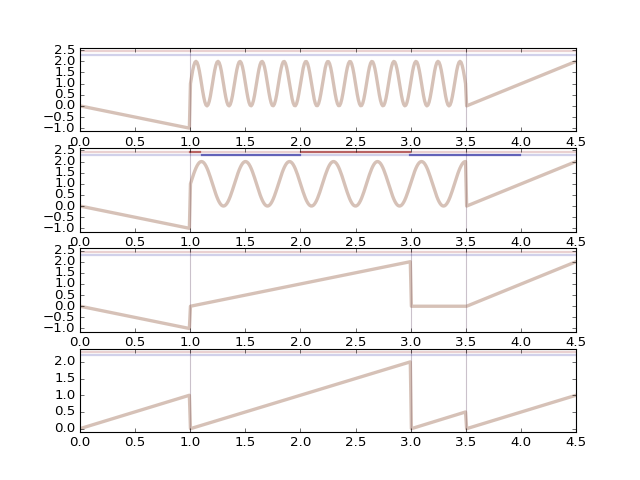

In [12]:
# Finally, we may provide a sample rate and durations and plot and forge the segments
durations = [1, 2, 0.5, 1]
SR = 100

# plot, see that everything we did above makes sense
pb.bluePrintPlotter([bp1, bp2, bp3, bp4], 100, durations)

# The two lines above the waveform represent marker1 (red) and marker2 (blue), respectively

In [9]:
# forge (not very useful at the moment, but here for completeness)
elem1, newdurs = pb.elementBuilder(bp2, SR, durations)

# the elementBuilder returns the element as a np.array containing (wfm, m1, m2). For plotting purposes, an adjusted
# list of durations (newdurs) is returned as well

print(type(elem1), np.shape(elem1))

<class 'numpy.ndarray'> (3, 450)


## More advanced examples

### Multiple argument replacement

<IPython.core.display.Javascript object>


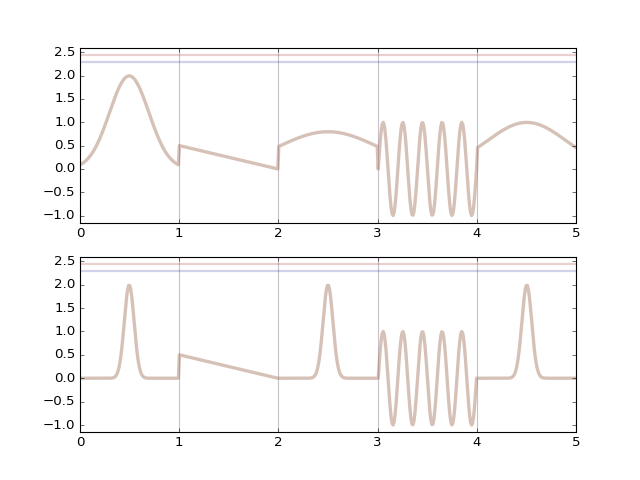

In [16]:
gaussian = pb.PulseAtoms.gaussian

# we make a blueprint with some gaussians
gbp = pb.BluePrint([gaussian, ramp, gaussian, sine, gaussian],
                   [(1, 0.2, 0, 0), (-0.5, 0.5), (1, 0.5, 0, 0), (5, 1, 0), (1, 0.4, 0, 0)],
                   ['', '', '', '', ''])

# and realise that all sigmas where way too large...
# Make the gaussians thinner and smaller
gbp2 = gbp.copy()
gbp2.changeArg('gaussian', 'sigma', 0.05, replaceeverywhere=True)
gbp2.changeArg('gaussian', 'ampl', 0.25, replaceeverywhere=True)
pb.bluePrintPlotter([gbp, gbp2], SR, [1, 1, 1, 1, 1])

<IPython.core.display.Javascript object>


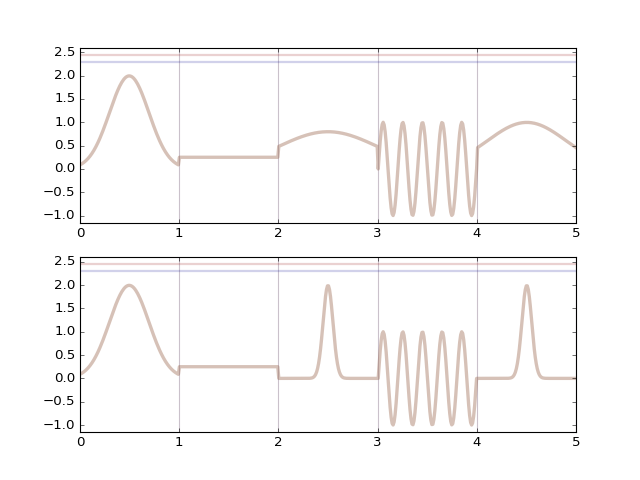

In [19]:
# The 'replaceeverywhere' looks for similar names, so naming can be used to discriminate 

# we make a blueprint with some gaussians
gbp = pb.BluePrint([gaussian, ramp, gaussian, sine, gaussian],
                   [(1, 0.2, 0, 0), (0, 0.25), (1, 0.5, 0, 0), (5, 1, 0), (1, 0.4, 0, 0)],
                   ['badgauss', '', 'goodgauss', '', 'goodgauss'])

# and realise that all sigmas where way too large...
# Make the gaussians thinner and smaller
gbp2 = gbp.copy()
gbp2.changeArg('goodgauss', 'sigma', 0.05, replaceeverywhere=True)
gbp2.changeArg('goodgauss', 'ampl', 0.25, replaceeverywhere=True)
pb.bluePrintPlotter([gbp, gbp2], SR, [1, 1, 1, 1, 1])

### Using the 'waituntil' special function

<IPython.core.display.Javascript object>


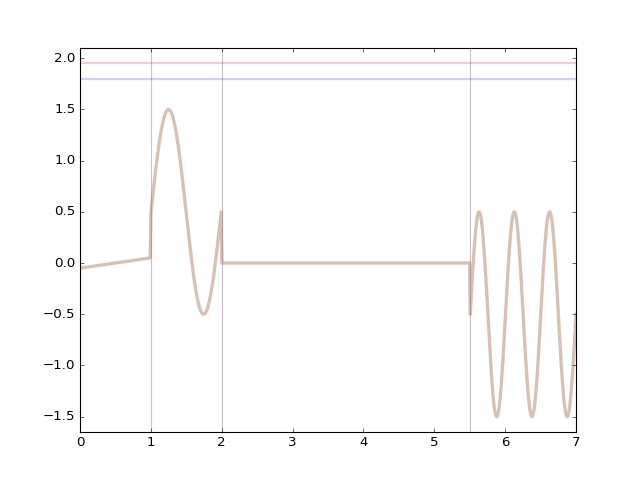

/Users/william/QCoDeS/qcodes/instrument_drivers/tektronix/pulsebuilding.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return list(np.zeros(dur*SR))


In [23]:
# The 'waituntil' function is utilised by adding the string 'waituntil' as a function. The corresponding argument
# is the ABSOLUTE time at which the NEXT segment should begin

bpwait = pb.BluePrint([ramp, sine, 'waituntil', sine],
                      [(0.1, -0.05), (1, 1, 0.5), (5.5,), (2, 1, -0.5)],
                      ['', '', '', ''])

# When plotting/forging, no duration should be specified for the 'waituntil' segment
pb.bluePrintPlotter(bpwait, SR, [1, 1, 1.5])                                

### Binding markers to specific segments

<IPython.core.display.Javascript object>


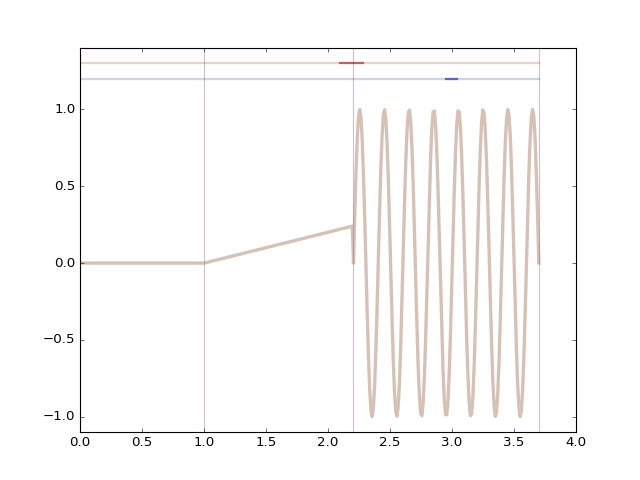

<IPython.core.display.Javascript object>


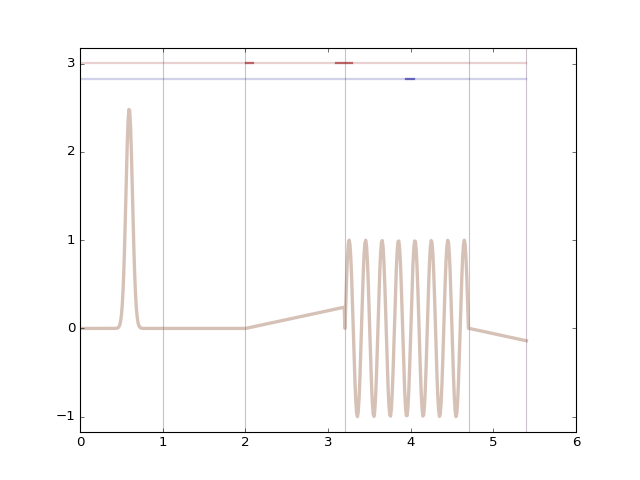

In [29]:
# It might be useful to have a marker indicating that some segment has been (or will soon be) reached

bp = pb.BluePrint([], [], [])
bp.insertSegment(0, ramp, (0, 0))
bp.insertSegment(1, ramp, (0.2, 0))
bp.insertSegment(2, sine, (5, 1, 0))  # This is the important segment
# make marker 1 go ON a bit before the sine comes on
bp.setSegmentMarker('sine', (-0.1, 0.2), 1)  # segment name, (delay, duration), markerID
# make marker 2 go ON halfway through the sine
bp.setSegmentMarker('sine', (0.75, 0.1), 2)

durations = [1, 1.2, 1.5]
pb.bluePrintPlotter(bp, SR, durations)

# Now we realise that we forgot to insert some segments...
bp.insertSegment(0, gaussian, (0.25, 0.04, 0.1, 0))
bp.insertSegment(-1, ramp, (-0.2, 0))
# and that we want a marker at 2s
bp.marker1 = [(2, 0.1)]

# The markers for the sine are still correctly bound:
pb.bluePrintPlotter(bp, SR, [1] + durations + [0.7])

# NB: the two different ways of inputting markers will never directly conflict, since one only specifies when to turn 
# markers ON. It is up to the user to ensure that markers switch off again as expected, i.e. that different marker
# specifications do not overlap.